In [307]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from experiment import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation, InputLayer, Flatten

# loading resnet
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

# for softplus
from vis.utils.utils import apply_modifications
from keras.activations import softplus
from keras.utils import CustomObjectScope

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
# creating resnet model
model = VGG16(weights = 'imagenet')

In [309]:
def softplus10(x):
    scaler = 10.0
    return softplus(x * scaler) / scaler

In [310]:
# replacing ReLU with SoftPlus10
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'activation'):
        if layer.activation.__name__ == 'relu':
            layer.activation = softplus10
            #print(i)
            #print(layer.activation.__code__)

In [311]:
with CustomObjectScope({'softplus10': softplus10}):
    model = apply_modifications(model)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [312]:
model.layers

In [314]:
# works for L0 (output), does not work after first convolutional layer. Why? Is it because of MaxPooling?
l = -1
print('Lmax %d l %d' % (len(model.layers) - 1, l))
if l == -1:
    model_cut = Model(inputs = model.inputs, outputs = model.layers[l].output)
else:
    model_cut = Model(inputs = model.inputs, outputs = Dense(1, kernel_initializer = 'ones')(Flatten()(model.layers[l].output)))

Lmax 22 l -1


In [337]:
# downscale image side
d = 60

# new (small) input
input_tensor = Input(shape = (d, d, 3))

# new model taking small images and upscaling them
out = model_cut(Lambda(lambda x : tf.image.resize_images(x, (224, 224)))(input_tensor))
model_upscale = Model(inputs = input_tensor, outputs = out)

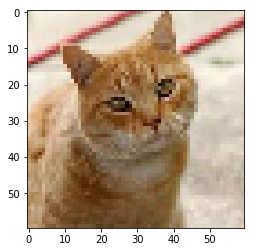

In [338]:
# getting picture of a cat
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(d, d))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

In [340]:
if l == -1:
    print(decode_predictions(model_upscale.predict(x), top=3)[0])
else:
    print(model_upscale.predict(x))

[('n02127052', 'lynx', 0.76147413), ('n02124075', 'Egyptian_cat', 0.12588786), ('n03958227', 'plastic_bag', 0.019392902)]


In [341]:
# probability of input failure
p = 0.0001

In [342]:
# calculating np
n = np.prod(list(map(int, model_upscale.inputs[0].shape[1:])))
n, n * p

(10800, 1.08)

In [343]:
to_keep = np.array(np.argsort(-model_upscale.predict(x))[0][:5], dtype = np.int32)

In [344]:
def SliceLayer(to_keep):
    """ Keep only these components in the layer """
    return Lambda(lambda x : tf.gather(x, to_keep, axis = 1))

In [345]:
to_keep

array([287, 285, 728, 279, 281], dtype=int32)

In [346]:
model_slice = Model(inputs = model_upscale.input, outputs = SliceLayer(to_keep)(model_upscale.output))

In [347]:
class ModelInputCrashExperiment(Experiment):
    def __init__(self, model, p=0.01, name='exp'):
        """ Get an experiment based on a model, assuming input failures
            p failures at input
        """

        # saving p_inference
        self.p_inference = [0, p]
        
        in_shape = model.layers[0].input.shape[1:]
        out_shape = model.layers[-1].output.shape[1:]
        assert len(out_shape) == 1, "Only support 1D output"
        out_N = int(out_shape[0])

        # rewrite using https://github.com/raghakot/keras-vis/issues/37
        self.N = [0, 0, out_N]
        
        def IdentityLayer(input_shape=None):
            """ A layer which does nothing """
            return Lambda(
                lambda x: x + 0, input_shape=input_shape, name='Identity')

        # creating correct and crashing models
        inp = Input(shape = in_shape)
        self.model_correct  = Model(inputs = inp, outputs = model(IdentityLayer     (   input_shape = in_shape)(inp)))
        self.model_crashing = Model(inputs = inp, outputs = model(IndependentCrashes(p, input_shape = in_shape)(inp)))

In [348]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model_slice, p = p)

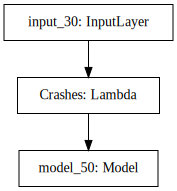

In [349]:
# plotting crashing architecture
SVG(model_to_dot(exp.model_crashing).create(prog='dot', format='svg'))

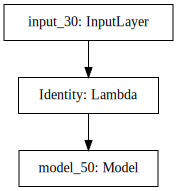

In [350]:
# plotting correct architecture
SVG(model_to_dot(exp.model_correct).create(prog='dot', format='svg'))

In [351]:
def predict(model, x):
    preds = model.predict(x)
    result = np.zeros(1000)
    preds = model.predict(x)
    for i, key in enumerate(to_keep):
        result[key] = preds[0][i]
    result = result.reshape(-1, 1000)
    print('Predicted:', decode_predictions(result, top=3)[0])

In [352]:
predict(exp.model_crashing, x)

Predicted: [('n02127052', 'lynx', 0.7690790891647339), ('n02124075', 'Egyptian_cat', 0.12496111541986465), ('n03958227', 'plastic_bag', 0.019616752862930298)]


In [353]:
predict(exp.model_correct, x)

Predicted: [('n02127052', 'lynx', 0.7614741325378418), ('n02124075', 'Egyptian_cat', 0.12588785588741302), ('n03958227', 'plastic_bag', 0.01939290203154087)]


In [354]:
r = exp.get_bound_b3(x)

In [355]:
r['mean']

array([-4.0127397e-05,  1.0157621e-05,  3.5976223e-06,  3.2561968e-06,
        3.0996734e-06], dtype=float32)

In [360]:
np.mean(exp.compute_error(x, repetitions = 1000), axis = 1)

array([[-0.01934077,  0.00588926,  0.00480485, -0.00059335,  0.00091156]],
      dtype=float32)

In [46]:
K = 1000
k = 100

In [47]:
datas = [exp.compute_error(np.array(x), repetitions = K) for _ in tqdm(range(k))]

100%|██████████| 100/100 [05:13<00:00,  3.14s/it]


In [3]:
fn = 'ConvNetTest-ResNet.pkl'

In [44]:
pickle.dump(datas, open(fn, 'wb'))

In [4]:
datas = pickle.load(open(fn, 'rb'))

In [48]:
np.mean(np.hstack(datas), axis = 1)

array([[-3.7679126e-04, -9.2434289e-04, -7.7110069e-04, -2.9466470e-04,
         3.6037607e-05]], dtype=float32)

In [42]:
exp.model_correct.layers[1]

In [46]:
exp.model_correct.layers[0].output

<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>